In [ ]:
!pip install av
!pip install gdown

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
from fastai.vision.all import *
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# descargamos los datos
!gdown XXXXXXXXXXXXXXx



In [ ]:
# descomprimimos el zip
!unzip -qq data.zip -d tfm-data

mapname:  conversion of  failed


In [ ]:
# cargamos el dataset con el FEVI por cada video
df = pd.read_csv('/content/tfm-data/target.csv')
df.head()

,FileName,FEVI
0,0X1A030EFDD45062FA,44.485700
1,0X1A05829AEDF6C65,64.078050
2,0X1A05DFFFCAFB253B,65.143601
3,0X1A09BE7969DA1508,69.566347
4,0X1A0A263B22CCD966,65.454529


In [ ]:
# asignamos target 1 a pacientes con FEVI < 50
df['target'] = np.where(df['FEVI'] < 50, 1, 0)
df['target'].value_counts()

0    1151
1     329
Name: target, dtype: int64

In [ ]:
df['FEVI10'] = df['FEVI'] // 10
df.loc[df['FEVI10'] == 0, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 1, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 2, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 8, 'FEVI10'] = 6
df.loc[df['FEVI10'] == 7, 'FEVI10'] = 6
df['FEVI10'].value_counts()

6.0    685
5.0    466
3.0    195
4.0    134
Name: FEVI10, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  1480 non-null   object 
 1   FEVI      1480 non-null   float64
 2   target    1480 non-null   int64  
 3   FEVI10    1480 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 46.4+ KB


In [ ]:
# vamos a trabajar en el directorio en el que están los datos
%cd ./tfm-data

/content/tfm-data


In [ ]:
# usamos Path para acceder más fácilmente
data_path = Path('./videos')
data_path.ls()

(#1480) [Path('videos/0X1F1EBF404A2CBB95.avi'),Path('videos/0X3FAD7F576C576B76.avi'),Path('videos/0X2F3A223D2AC5A8C9.avi'),Path('videos/0X3BC79FE68CD2CED5.avi'),Path('videos/0X2A0B8E212C49D706.avi'),Path('videos/0X1A2629BF0939E381.avi'),Path('videos/0X2F3ABF4B8389713F.avi'),Path('videos/0X2BB8F8D3346376DA.avi'),Path('videos/0X3E54E90C8CF89B22.avi'),Path('videos/0X3F9A02817B34BB11.avi')...]

In [ ]:
# con get_files obtenemos referencias a los ficheros de los videos
video_paths = get_files(data_path, extensions='.avi')
video_paths[0:4]

(#4) [Path('videos/0X1F1EBF404A2CBB95.avi'),Path('videos/0X3FAD7F576C576B76.avi'),Path('videos/0X2F3A223D2AC5A8C9.avi'),Path('videos/0X3BC79FE68CD2CED5.avi')]

In [ ]:
import av

In [ ]:
# función para convertir un video a una secuencia de imágenes
def extract_frames(video_path):
    video = av.open(str(video_path))
    for frame in video.decode(0):
        yield frame.to_image()

In [ ]:
# comprobamos que funciona como esperamos, nos devuelve una lista de imágenes
frames = list(extract_frames(video_paths[0]))
frames[0:4]

[<PIL.Image.Image image mode=RGB size=112x112>,
 <PIL.Image.Image image mode=RGB size=112x112>,
 <PIL.Image.Image image mode=RGB size=112x112>,
 <PIL.Image.Image image mode=RGB size=112x112>]

In [ ]:
len(frames)

160

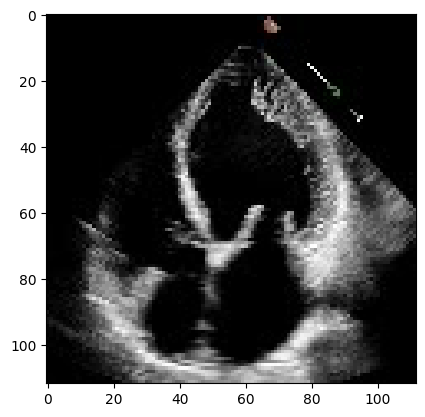

In [ ]:
# comprobamos que los frames se ven correctamente
plt.imshow(frames[50], cmap="binary", interpolation="nearest")

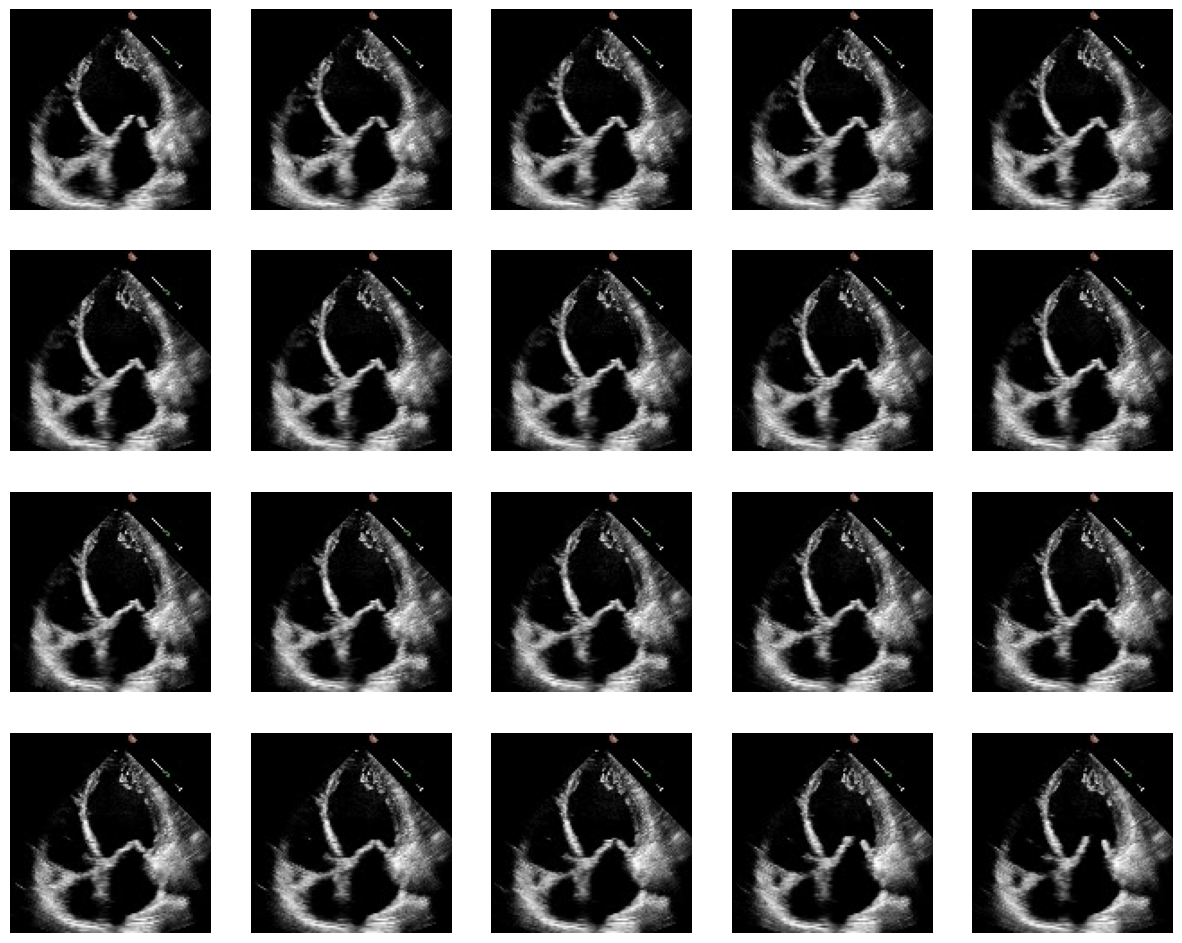

In [ ]:
# podemos mostrar una secuencia de frames
show_images(frames[0:20], nrows=4)

In [ ]:
# usando PyAv podemos extraer información de los videos
video = av.open(str(video_paths[0]))
stream = video.streams[0]

print(f"codec: {stream.codec_context.name}")
print(f"frame rate: {stream.average_rate} fps")
print(f"total frames: {stream.frames}")
print(f"duration: {float(stream.duration / stream.average_rate)} sec")
print(f"dimensions: {stream.width} x {stream.height}")

codec: mjpeg
frame rate: 50 fps
total frames: 160
duration: 3.2 sec
dimensions: 112 x 112


In [ ]:
# vamos a extraer estos datos para todos los videos
rows = []
for row_id in range(0, len(df)):
  video_id = df.iloc[row_id]['FileName']
  stream = av.open(str(data_path/f"{video_id}.avi")).streams[0]
  tmp_row = {
    'codec': stream.codec_context.name,
    'frame_rate': stream.average_rate,
    'frames': stream.frames,
    'duration': float(stream.duration / stream.average_rate),
    'dim': f"{stream.width} x {stream.height}"
    }
  rows.append(tmp_row)

tmp_df = pd.DataFrame(rows)
tmp_df.head()

,codec,frame_rate,frames,duration,dim
0,mjpeg,50,157,3.14,112 x 112
1,mjpeg,50,178,3.56,112 x 112
2,mjpeg,50,166,3.32,112 x 112
3,mjpeg,50,149,2.98,112 x 112
4,mjpeg,50,140,2.80,112 x 112


In [ ]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   codec       1480 non-null   object 
 1   frame_rate  1480 non-null   object 
 2   frames      1480 non-null   int64  
 3   duration    1480 non-null   float64
 4   dim         1480 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 57.9+ KB


In [ ]:
# convertimos el frame rate a integer
tmp_df['frame_rate'] = tmp_df['frame_rate'].astype(int)

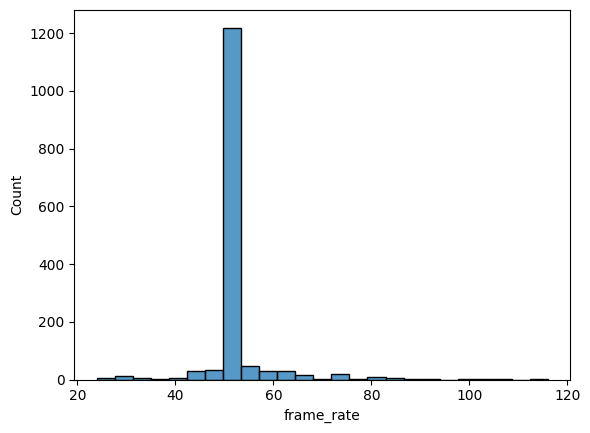

In [ ]:
sns.histplot(x='frame_rate', data=tmp_df, bins=25)
plt.show()

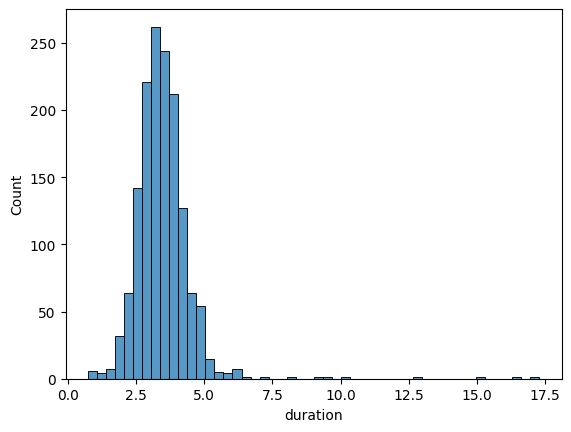

In [ ]:
sns.histplot(x='duration', data=tmp_df, bins=50)
plt.show()

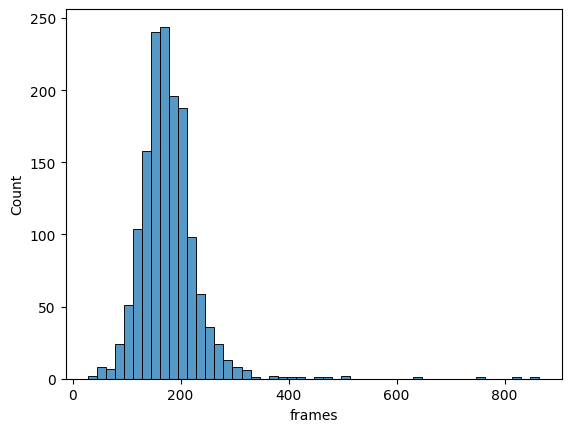

In [ ]:
sns.histplot(x='frames', data=tmp_df, bins=50)
plt.show()

<Axes: xlabel='codec', ylabel='count'>

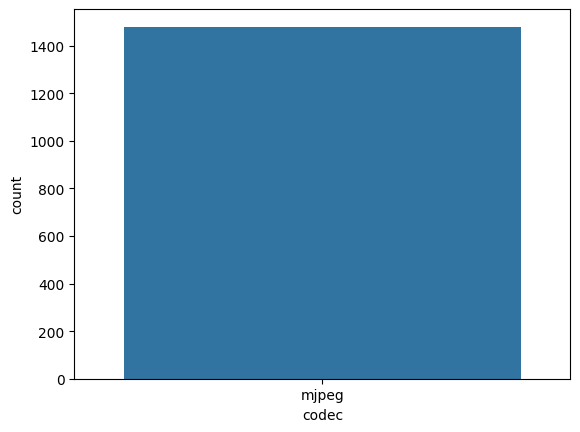

In [ ]:
sns.countplot(x='codec', data=tmp_df)

<Axes: xlabel='dim', ylabel='count'>

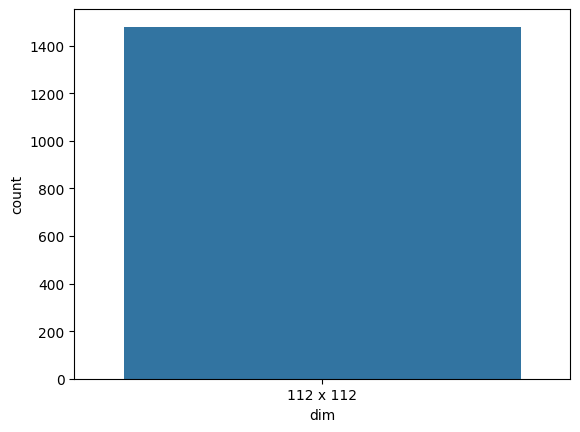

In [ ]:
sns.countplot(x='dim', data=tmp_df)

In [ ]:
# concatenamos los metadatos con el dataframe que tenemos con los targets
df = pd.concat([df, tmp_df[['frame_rate', 'frames', 'duration']]], axis=1)

df.shape

(1480, 7)

In [ ]:
df.head()

,FileName,FEVI,target,FEVI10,frame_rate,frames,duration
0,0X1A030EFDD45062FA,44.485700,1,4.0,50,157,3.14
1,0X1A05829AEDF6C65,64.078050,0,6.0,50,178,3.56
2,0X1A05DFFFCAFB253B,65.143601,0,6.0,50,166,3.32
3,0X1A09BE7969DA1508,69.566347,0,6.0,50,149,2.98
4,0X1A0A263B22CCD966,65.454529,0,6.0,50,140,2.80


<Axes: xlabel='FEVI', ylabel='Count'>

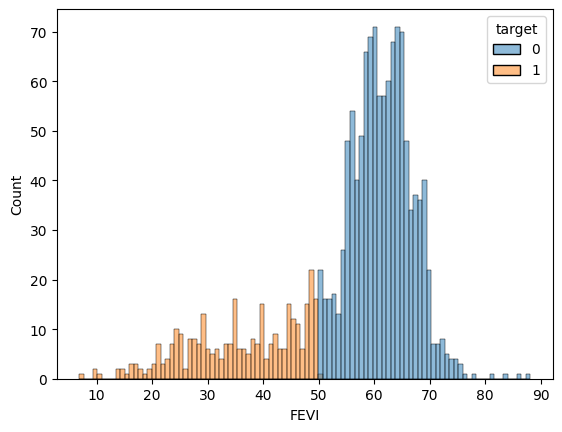

In [ ]:
sns.histplot(x='FEVI', hue='target', data=df, bins=100)

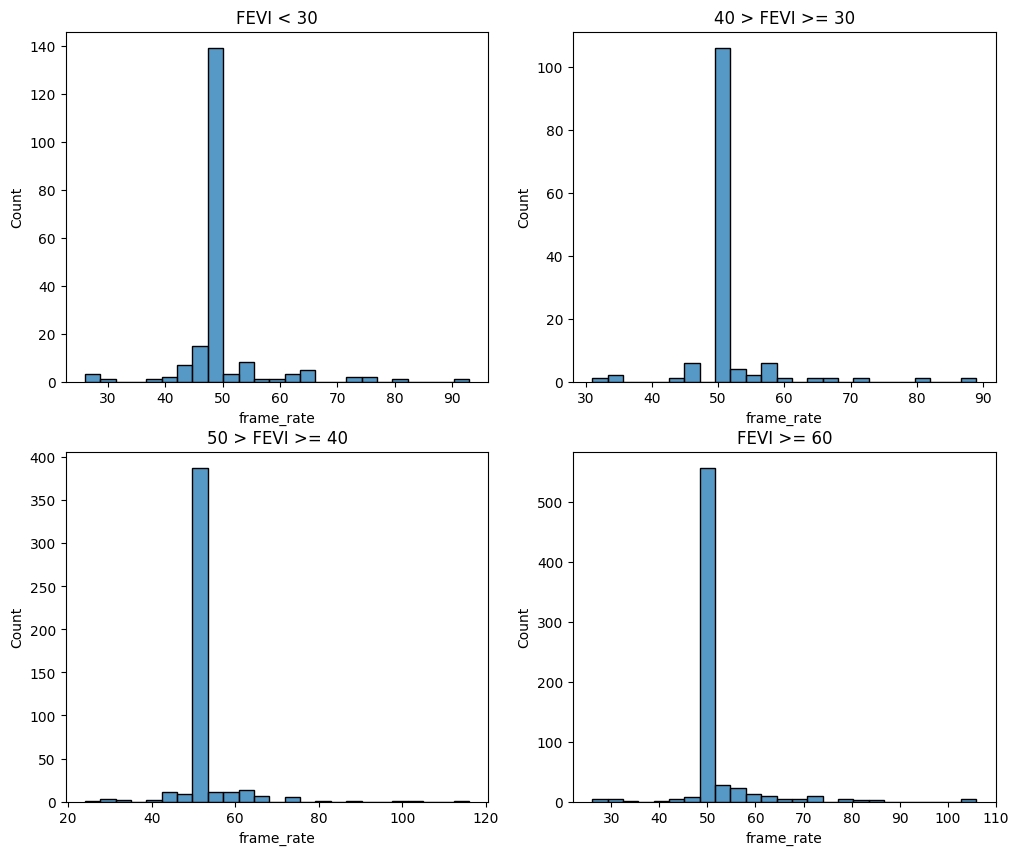

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

sns.histplot(x='frame_rate', data=df[df['FEVI10'] == 3], bins=25, ax=axes[0,0]).set(title="FEVI < 30")
sns.histplot(x='frame_rate', data=df[df['FEVI10'] == 4], bins=25, ax=axes[0,1]).set(title="40 > FEVI >= 30")
sns.histplot(x='frame_rate', data=df[df['FEVI10'] == 5], bins=25, ax=axes[1,0]).set(title="50 > FEVI >= 40")
sns.histplot(x='frame_rate', data=df[df['FEVI10'] == 6], bins=25, ax=axes[1,1]).set(title="FEVI >= 60")


plt.show()

<Axes: xlabel='frame_rate', ylabel='Count'>

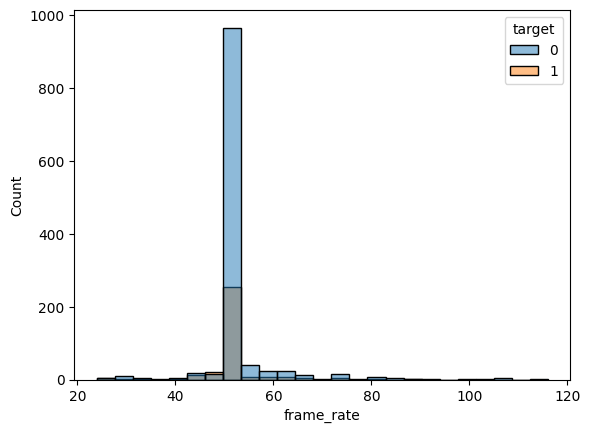

In [ ]:
sns.histplot(x='frame_rate', hue='target', data=df, bins=25)

<Axes: xlabel='frame_rate', ylabel='Count'>

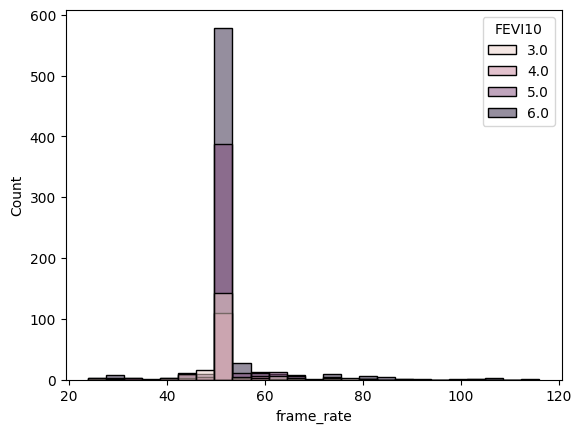

In [ ]:
sns.histplot(x='frame_rate', hue='FEVI10', data=df, bins=25)

<Axes: xlabel='duration', ylabel='Count'>

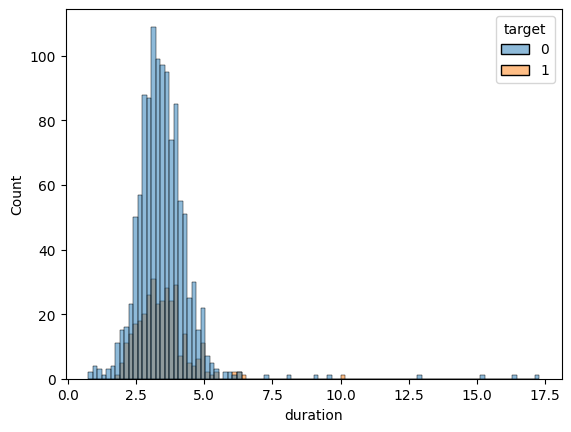

In [ ]:
sns.histplot(x='duration', hue='target', data=df, bins=100)

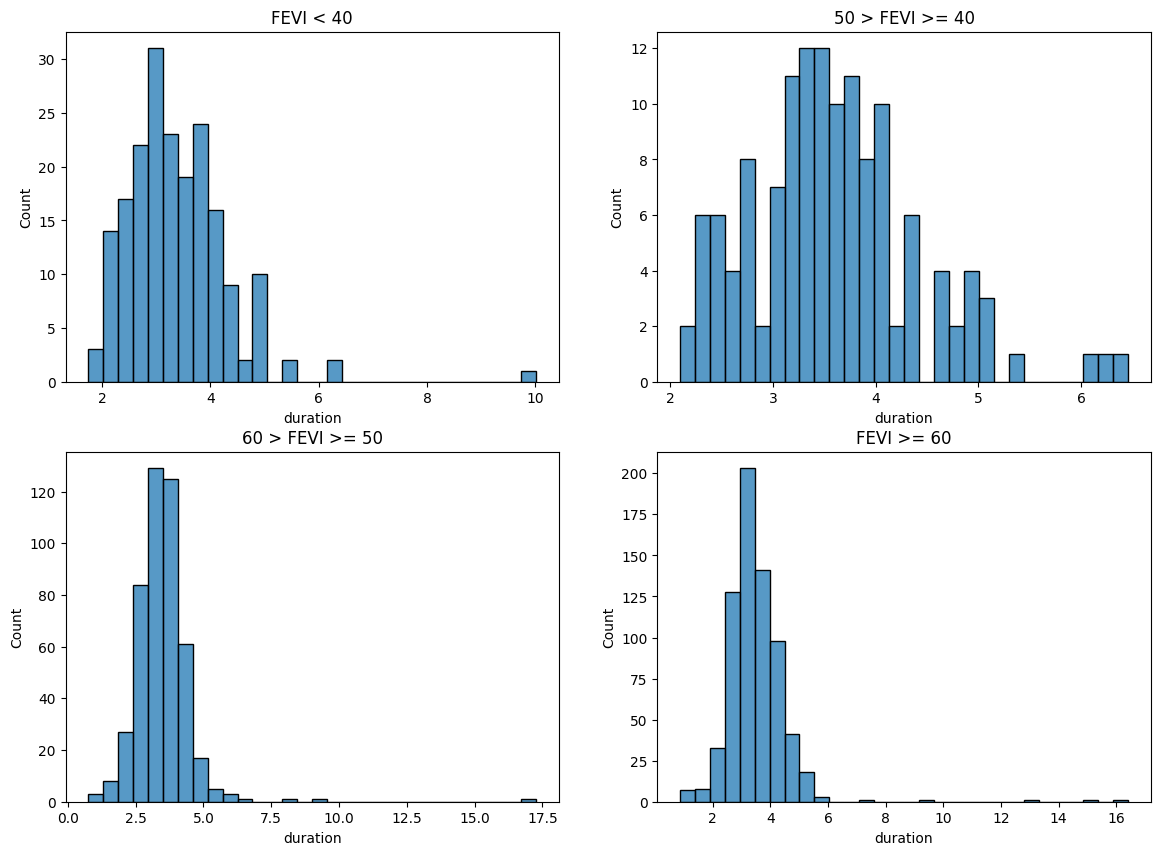

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,10))

sns.histplot(x='duration', data=df[df['FEVI10'] == 3], bins=30, ax=axes[0,0]).set(title="FEVI < 40")
sns.histplot(x='duration', data=df[df['FEVI10'] == 4], bins=30, ax=axes[0,1]).set(title="50 > FEVI >= 40")
sns.histplot(x='duration', data=df[df['FEVI10'] == 5], bins=30, ax=axes[1,0]).set(title="60 > FEVI >= 50")
sns.histplot(x='duration', data=df[df['FEVI10'] == 6], bins=30, ax=axes[1,1]).set(title="FEVI >= 60")


plt.show()

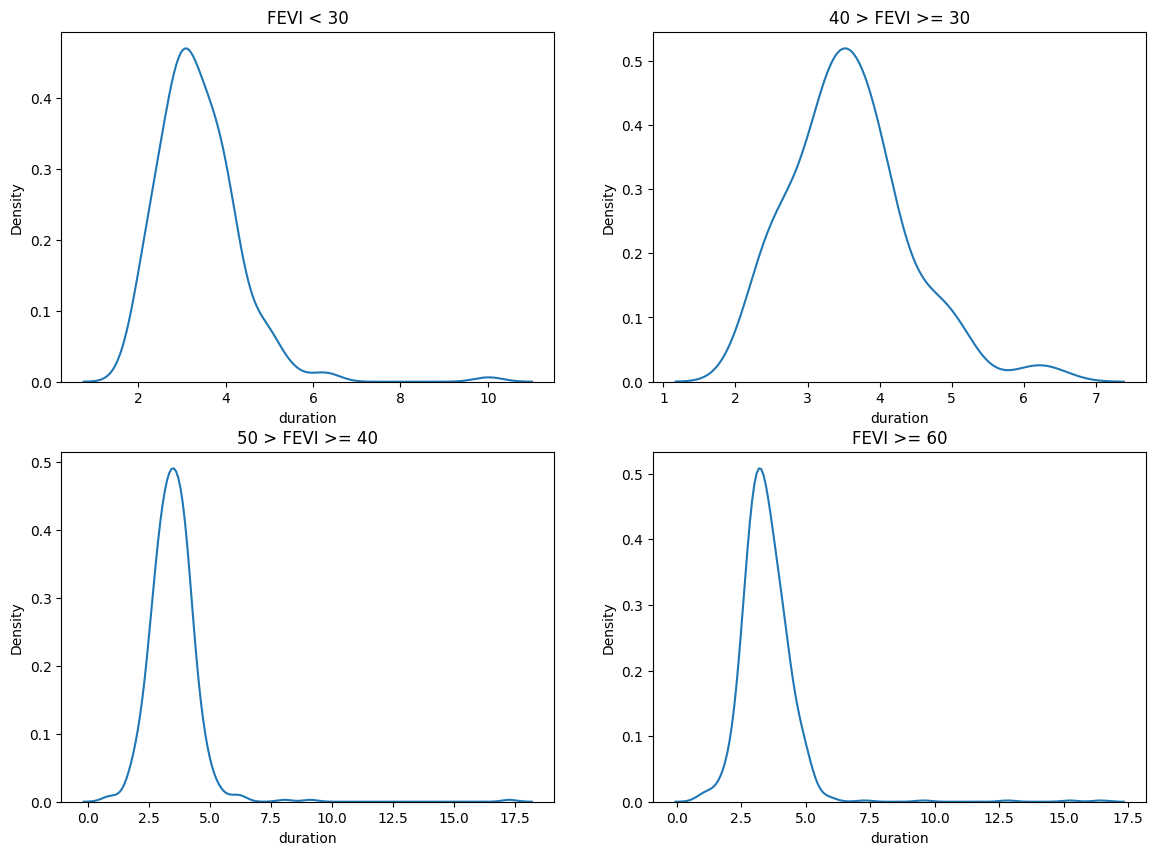

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,10))

sns.kdeplot(x='duration', data=df[df['FEVI10'] == 3], ax=axes[0,0]).set(title="FEVI < 30")
sns.kdeplot(x='duration', data=df[df['FEVI10'] == 4], ax=axes[0,1]).set(title="40 > FEVI >= 30")
sns.kdeplot(x='duration', data=df[df['FEVI10'] == 5], ax=axes[1,0]).set(title="50 > FEVI >= 40")
sns.kdeplot(x='duration', data=df[df['FEVI10'] == 6], ax=axes[1,1]).set(title="FEVI >= 60")


plt.show()

<Axes: xlabel='frames', ylabel='Count'>

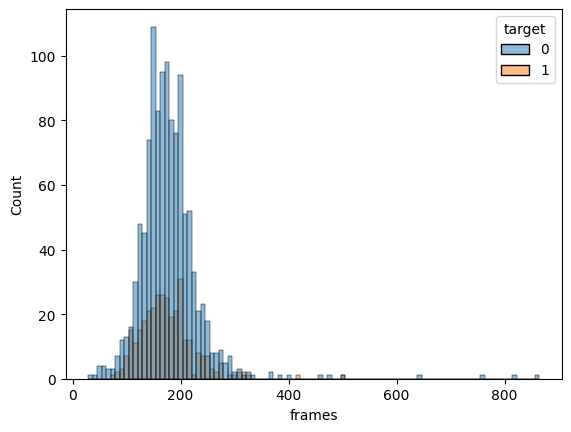

In [ ]:
sns.histplot(x='frames', hue='target', data=df, bins=100)

<Axes: xlabel='frames', ylabel='Count'>

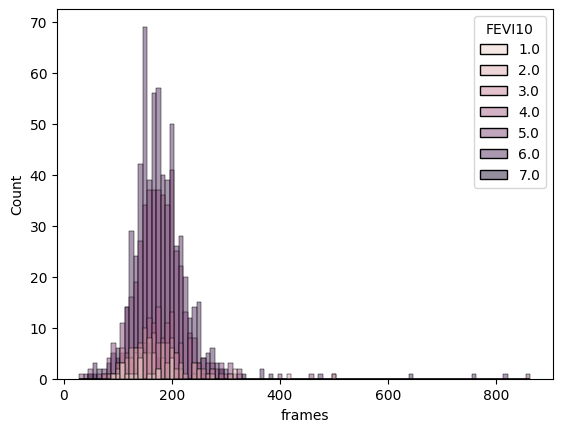

In [ ]:
sns.histplot(x='frames', hue='FEVI10', data=df, bins=100)

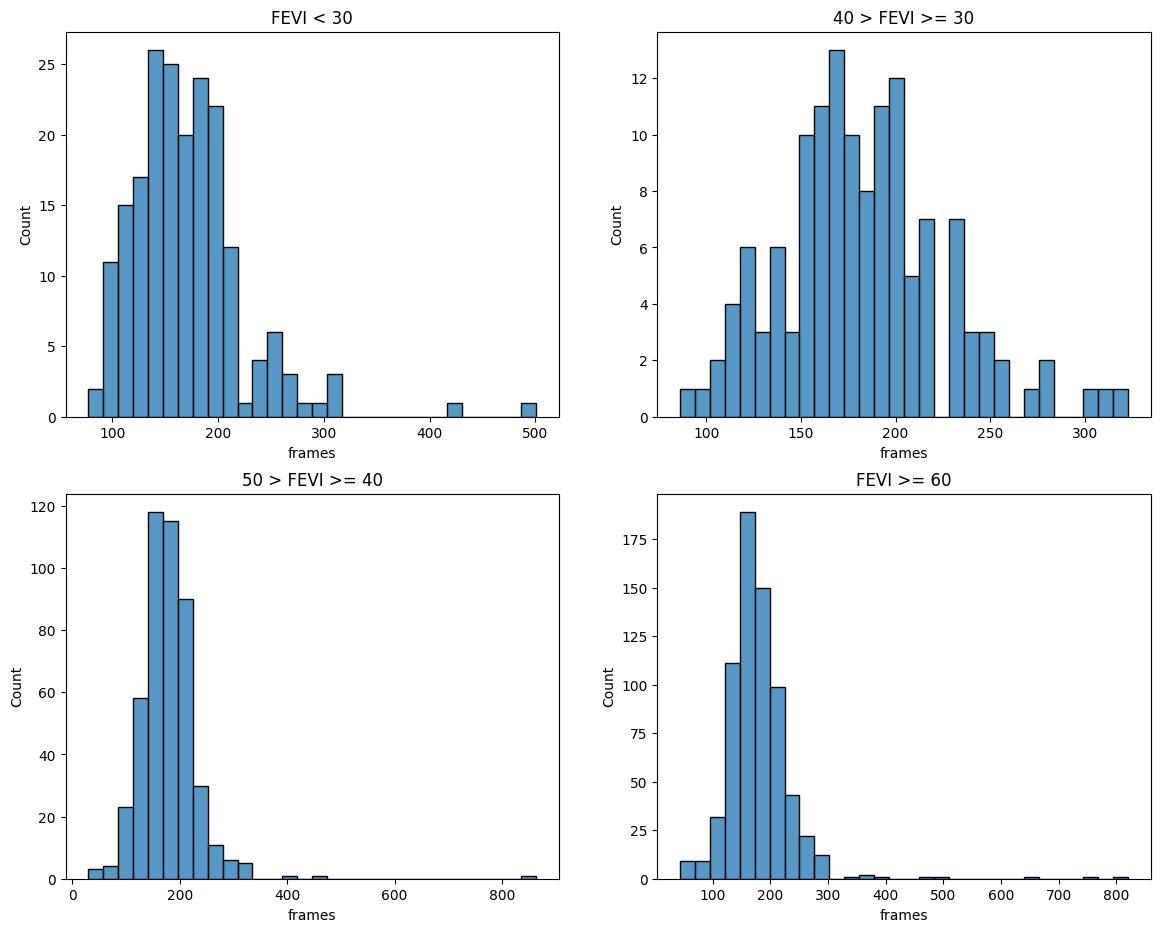

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,11))

sns.histplot(x='frames', data=df[df['FEVI10'] == 3], bins=30, ax=axes[0,0]).set(title="FEVI < 30")
sns.histplot(x='frames', data=df[df['FEVI10'] == 4], bins=30, ax=axes[0,1]).set(title="40 > FEVI >= 30")
sns.histplot(x='frames', data=df[df['FEVI10'] == 5], bins=30, ax=axes[1,0]).set(title="50 > FEVI >= 40")
sns.histplot(x='frames', data=df[df['FEVI10'] == 6], bins=30, ax=axes[1,1]).set(title="FEVI >= 60")


plt.show()

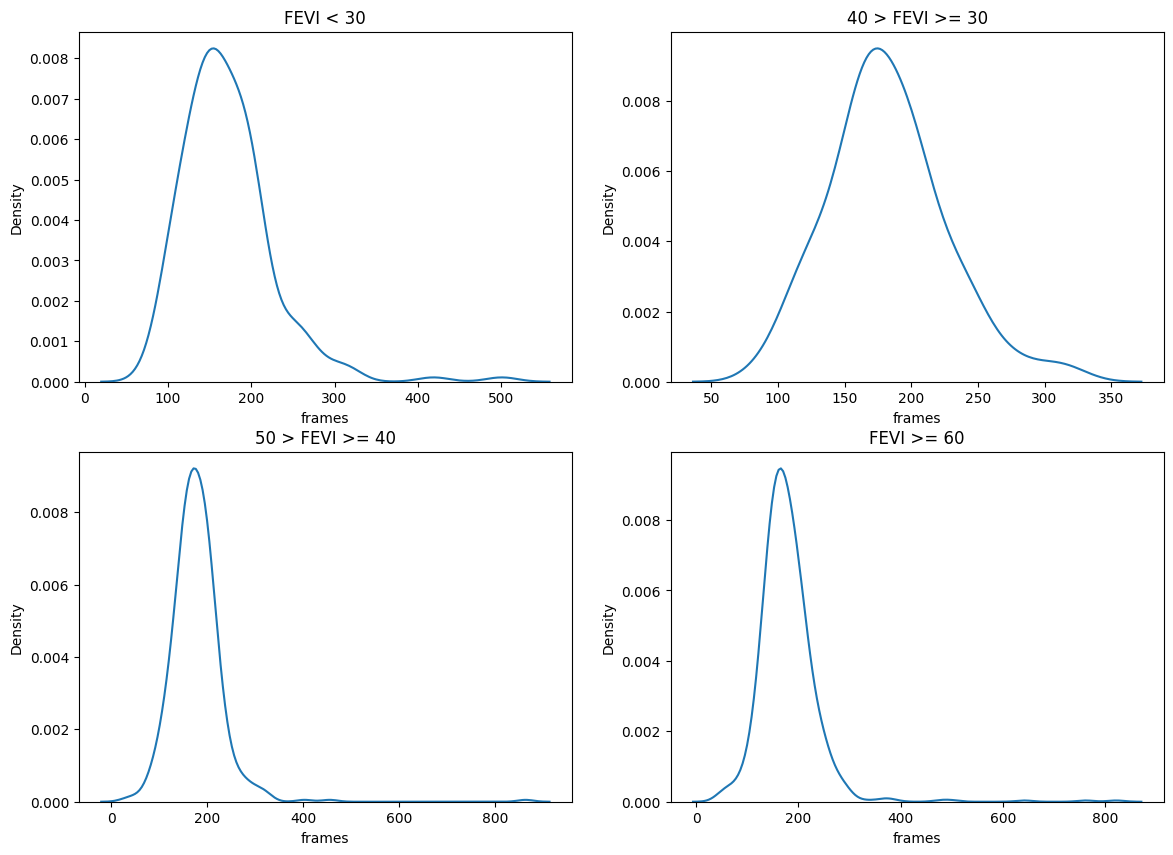

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14,10))

sns.kdeplot(x='frames', data=df[df['FEVI10'] == 3], ax=axes[0,0]).set(title="FEVI < 30")
sns.kdeplot(x='frames', data=df[df['FEVI10'] == 4], ax=axes[0,1]).set(title="40 > FEVI >= 30")
sns.kdeplot(x='frames', data=df[df['FEVI10'] == 5], ax=axes[1,0]).set(title="50 > FEVI >= 40")
sns.kdeplot(x='frames', data=df[df['FEVI10'] == 6], ax=axes[1,1]).set(title="FEVI >= 60")


plt.show()

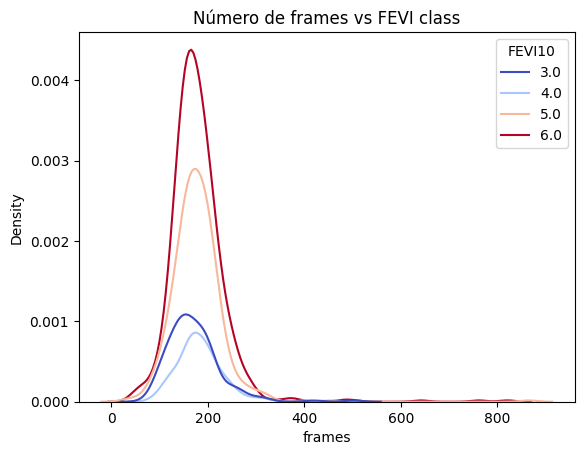

In [ ]:
sns.kdeplot(x='frames', data=df, hue='FEVI10', palette='coolwarm').set(title="Número de frames vs FEVI class")
plt.show()

<Axes: xlabel='FEVI', ylabel='Count'>

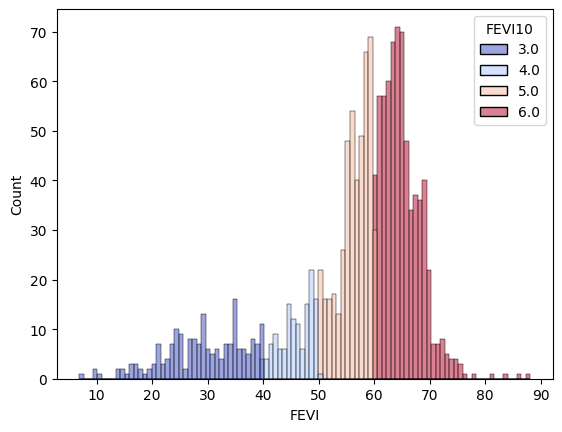

In [ ]:
sns.histplot(x='FEVI', hue='FEVI10', data=df, bins=100, palette='coolwarm')

<Axes: xlabel='FEVI', ylabel='frames'>

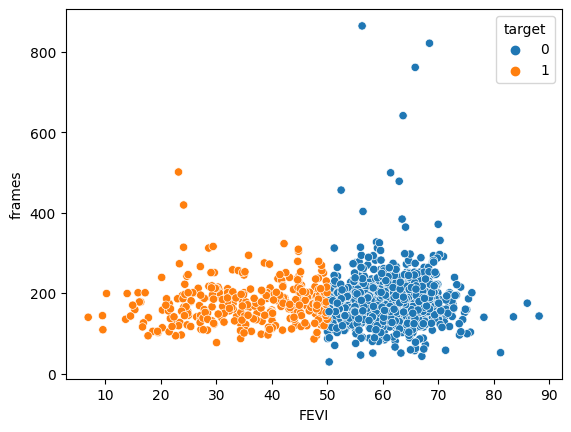

In [ ]:
sns.scatterplot(data=df, x="FEVI", y="frames", hue="target")

In [ ]:
df[['FEVI', 'frame_rate', 'frames', 'duration']].describe()

,FEVI,frame_rate,frames,duration
count,1480.000000,1480.000000,1480.000000,1480.000000
mean,55.873669,51.253378,177.821622,3.476358
std,12.575101,7.048944,57.288630,1.056785
min,6.907258,24.000000,29.000000,0.743590
25%,51.773848,50.000000,147.000000,2.900000
50%,59.493729,50.000000,172.000000,3.400000
75%,64.098355,50.000000,201.000000,3.940000
max,88.142061,116.000000,864.000000,17.280000


In [ ]:
df[df['target'] == 1].describe()

,FEVI,target,FEVI10,frame_rate,frames,duration
count,329.000000,329.0,329.000000,329.000000,329.000000,329.000000
mean,36.003037,1.0,3.036474,50.693009,175.306991,3.458876
std,10.132212,0.0,0.949265,6.629110,50.983857,0.903989
min,6.907258,1.0,1.000000,26.000000,77.000000,1.740000
25%,28.385674,1.0,2.000000,50.000000,143.000000,2.860000
50%,37.138240,1.0,3.000000,50.000000,170.000000,3.380000
75%,45.099303,1.0,4.000000,50.000000,201.000000,3.920000
max,49.968968,1.0,4.000000,93.000000,501.000000,10.020000


In [ ]:
df[df['target'] == 0].describe()

,FEVI,target,FEVI10,frame_rate,frames,duration
count,1151.000000,1151.0,1151.000000,1151.000000,1151.000000,1151.000000
mean,61.553459,0.0,5.641182,51.413553,178.540400,3.481355
std,5.370741,0.0,0.567840,7.159132,58.967905,1.096861
min,50.003633,0.0,5.000000,24.000000,29.000000,0.743590
25%,57.964900,0.0,5.000000,50.000000,149.000000,2.920000
50%,61.519823,0.0,6.000000,50.000000,172.000000,3.400000
75%,65.075004,0.0,6.000000,50.000000,201.000000,3.943684
max,88.142061,0.0,7.000000,116.000000,864.000000,17.280000


In [ ]:
df[df['frames'] < 30]['FEVI10'].value_counts()

5.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 50]['FEVI10'].value_counts()

5.0    2
6.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 60]['FEVI10'].value_counts()

6.0    4
5.0    3
7.0    2
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 70]['FEVI10'].value_counts()

6.0    7
5.0    3
7.0    2
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 80]['FEVI10'].value_counts()

6.0    9
5.0    5
7.0    2
3.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 90]['FEVI10'].value_counts()

6.0    15
5.0    13
7.0     2
3.0     2
4.0     1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 100]['FEVI10'].value_counts()

6.0    18
5.0    17
7.0     4
3.0     4
4.0     2
2.0     2
1.0     1
Name: FEVI10, dtype: int64

In [ ]:
# la mayoría de los videos con menos de 100 frames son de pacientes sanos 5/6/7. Cuando queramos escoger un valor de start_frame alto,
# y también un valor alto de frames, estos grupos serán los más afectados.

In [ ]:
df[df['frames'] > 100]['FEVI10'].value_counts()

6.0    613
5.0    449
4.0    132
3.0     89
2.0     80
7.0     49
1.0     19
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] > 300]['FEVI10'].value_counts()

5.0    9
6.0    8
2.0    5
4.0    3
7.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frame_rate'] < 30]['frame_rate'].value_counts()

28    3
27    3
26    3
24    1
Name: frame_rate, dtype: int64

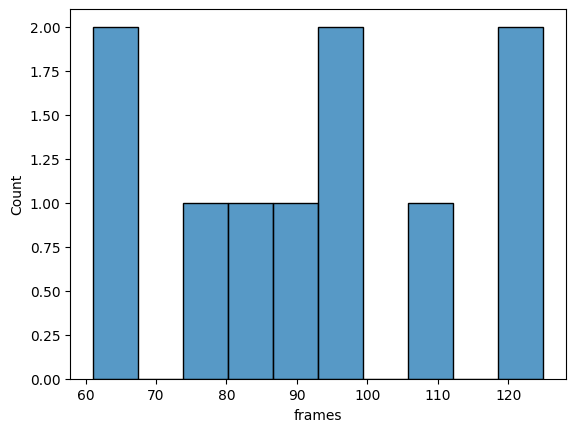

In [ ]:
sns.histplot(x='frames', data=df[df['frame_rate'] < 30], bins=10)
plt.show()

In [ ]:
df[df['frame_rate'] < 30]['FEVI10'].value_counts()

6.0    5
5.0    2
2.0    1
3.0    1
1.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['frames'] < 50]['frames'].value_counts()

46    1
43    1
29    1
Name: frames, dtype: int64

In [ ]:
# los videos de duración muy corta son muy pocos, no creemos que influyan
df[df['duration'] < 1]['FEVI10'].value_counts()

5.0    2
6.0    1
Name: FEVI10, dtype: int64

In [ ]:
df[df['duration'] < 2]['FEVI10'].value_counts()

6.0    15
5.0    14
7.0     5
3.0     2
Name: FEVI10, dtype: int64

In [ ]:
df[df['duration'] > 5]['FEVI10'].value_counts()

6.0    24
5.0    14
4.0     7
2.0     6
3.0     3
7.0     2
Name: FEVI10, dtype: int64

In [ ]:
df.to_csv("/content/gdrive/MyDrive/TFM/target_metadata.csv")